In [3]:
import numpy as np
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import time, sys
import pickle
from scipy.io import savemat

In [4]:
np.set_printoptions(threshold=sys.maxsize)

In [5]:
# Choose either Re=1000 or Re=100
Re=10000

# load FOM solutions
if Re==10000:
    nx=60
    ny=60
    nt=1500
    
    FOM_solution=pickle.load(open('./data/FOM_high_Re.p','rb'))
elif Re==100:
    nx=60
    ny=60
    nt=1500
    
    FOM_solution=pickle.load(open('./data/FOM_low_Re.p','rb'))
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))
    
u_full=FOM_solution['u']
v_full=FOM_solution['v']

u0=np.copy(u_full[0])
v0=np.copy(v_full[0])

# set parameters
nxy=(nx-2)*(ny-2)
dx=1/(nx-1)
dy=1/(ny-1)
dt=2/nt

I=sp.eye(nxy,format='csr')

# full indicies, free indicies, fixed indicies
[xv,yv]=np.meshgrid(np.linspace(0,1,nx),np.linspace(0,1,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
free_multi_index=(multi_index_j[1:-1,1:-1].flatten(),multi_index_i[1:-1,1:-1].flatten())
x0_multi_index=(multi_index_j[1:-1,0].flatten(),multi_index_i[1:-1,0].flatten())
x1_multi_index=(multi_index_j[1:-1,-1].flatten(),multi_index_i[1:-1,-1].flatten())
y0_multi_index=(multi_index_j[0,1:-1].flatten(),multi_index_i[0,1:-1].flatten())
y1_multi_index=(multi_index_j[-1,1:-1].flatten(),multi_index_i[-1,1:-1].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
free_raveled_indicies=np.ravel_multi_index(free_multi_index,dims)
x0_raveled_indicies=np.ravel_multi_index(x0_multi_index,dims)
x1_raveled_indicies=np.ravel_multi_index(x1_multi_index,dims)
x01_raveled_indicies=np.concatenate((x0_raveled_indicies,x1_raveled_indicies))
y0_raveled_indicies=np.ravel_multi_index(y0_multi_index,dims)
y1_raveled_indicies=np.ravel_multi_index(y1_multi_index,dims)
y01_raveled_indicies=np.concatenate((y0_raveled_indicies,y1_raveled_indicies))
fixed_raveled_indicies=np.setdiff1d(full_raveled_indicies,free_raveled_indicies)

# boundary one-hot vector
x0_one_hot=np.eye(nx-2)[0]
y0_one_hot=np.eye(ny-2)[0]
x1_one_hot=np.eye(nx-2)[-1]
y1_one_hot=np.eye(ny-2)[-1]

# inner grid
inner_multi_index_i,inner_multi_index_j=np.meshgrid(np.arange(nx-2),np.arange(ny-2),indexing='xy')
inner_x_multi_index=(np.concatenate((inner_multi_index_j[:,0].flatten(),inner_multi_index_j[:,-1].flatten())),
                     np.concatenate((inner_multi_index_i[:,0].flatten(),inner_multi_index_i[:,-1].flatten())))
inner_y_multi_index=(np.concatenate((inner_multi_index_j[0,:].flatten(),inner_multi_index_j[-1,:].flatten())),
                     np.concatenate((inner_multi_index_i[0,:].flatten(),inner_multi_index_i[-1,:].flatten())))

inner_dims=(ny-2,nx-2)
inner_x_raveled_indicies=np.ravel_multi_index(inner_x_multi_index,inner_dims)
inner_y_raveled_indicies=np.ravel_multi_index(inner_y_multi_index,inner_dims)

# set FOM solution (free DoFs)
u_fom=u_full[1:,free_raveled_indicies]
v_fom=v_full[1:,free_raveled_indicies]

u_ref=u_full[0,free_raveled_indicies]
v_ref=v_full[0,free_raveled_indicies]

# redDim
redDimArr_LSROM=np.array([3,5,10,15,20,25,30,35,40])

# avg. rel. errors
relErr_LSROM_g=np.zeros((2,redDimArr_LSROM.shape[0]))
relErr_LSROM_lspg=np.zeros((2,redDimArr_LSROM.shape[0]))

# max. rel. errors
maxErr_LSROM_g=np.zeros((2,redDimArr_LSROM.shape[0]))
maxErr_LSROM_lspg=np.zeros((2,redDimArr_LSROM.shape[0]))

# proj. errors
proErr_LSROM=np.zeros((2,redDimArr_LSROM.shape[0]))
for ii in range(len(redDimArr_LSROM)):
    redDim=redDimArr_LSROM[ii]
    
    # load POD basis
    if Re==10000:
        file_name_POD="./model/POD_high_Re_red-dim_{}.p".format(redDim)
    elif Re==100:
        file_name_POD="./model/POD_low_Re_red-dim_{}.p".format(redDim)
    else:
        raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))

    POD = pickle.load(open(file_name_POD,'rb'))

    phi_u = POD['u']
    phi_v = POD['v']

    phi_uT=phi_u.T
    phi_vT=phi_v.T

    proj_u=(np.eye(u_fom.shape[1])-phi_u.dot(phi_uT)).dot((u_fom-u_ref).T)
    pro_err_u=np.sqrt(np.sum(np.linalg.norm(proj_u,ord=2,axis=0)**2))/np.sqrt(np.sum(np.linalg.norm(u_fom,ord=2,axis=1)**2))*100
    proErr_LSROM[0,ii]=pro_err_u
    
    proj_v=(np.eye(v_fom.shape[1])-phi_v.dot(phi_vT)).dot((v_fom-v_ref).T)
    pro_err_v=np.sqrt(np.sum(np.linalg.norm(proj_v,ord=2,axis=0)**2))/np.sqrt(np.sum(np.linalg.norm(v_fom,ord=2,axis=1)**2))*100
    proErr_LSROM[1,ii]=pro_err_v

In [6]:
# first order derivative
# central
Mb=sp.diags([np.ones(nx-2),-np.ones(nx-2)],[0,-1],(nx-2,nx-2))
M=sp.kron(sp.eye(ny-2),Mb,format="csr")

Ib=sp.eye(nx-2)
N=sp.kron(sp.diags([np.ones(ny-2),-np.ones(ny-2)],[0,-1],(ny-2,ny-2)),Ib,format="csr")

# laplacian operator
Dxb=sp.diags([-2*np.ones(nx-2),np.ones(nx-2),np.ones(nx-2)],[0,-1,1],(nx-2,nx-2))
Dx=sp.kron(sp.eye(ny-2),Dxb,format="csr")

Ib=sp.eye(nx-2)
Dy=sp.kron(sp.diags([-2*np.ones(ny-2),np.ones(ny-2),np.ones(ny-2)],[0,-1,1],(ny-2,ny-2)),Ib,format="csr")

In [7]:
# boundary for first order derivative term
Bdudx0_cur=np.kron(u0[x0_raveled_indicies],x0_one_hot)
Bdudy0_cur=np.kron(y0_one_hot,u0[y0_raveled_indicies])
Bdvdx0_cur=np.kron(v0[x0_raveled_indicies],x0_one_hot)
Bdvdy0_cur=np.kron(y0_one_hot,v0[y0_raveled_indicies])
Bdudx1_cur=np.kron(u0[x1_raveled_indicies],x1_one_hot)
Bdudy1_cur=np.kron(y1_one_hot,u0[y1_raveled_indicies])
Bdvdx1_cur=np.kron(v0[x1_raveled_indicies],x1_one_hot)
Bdvdy1_cur=np.kron(y1_one_hot,v0[y1_raveled_indicies])
    
# boundary for second order derivative term
bxu_cur=np.zeros(nxy)
byu_cur=np.zeros(nxy)
bxv_cur=np.zeros(nxy)
byv_cur=np.zeros(nxy)

bxu_cur[inner_x_raveled_indicies]=u0[x01_raveled_indicies]
byu_cur[inner_y_raveled_indicies]=u0[y01_raveled_indicies]
bxv_cur[inner_x_raveled_indicies]=v0[x01_raveled_indicies]
byv_cur[inner_y_raveled_indicies]=v0[y01_raveled_indicies]

In [8]:
Mu_ref=M.dot(u_ref)
Nu_ref=N.dot(u_ref)
Mv_ref=M.dot(v_ref)
Nv_ref=N.dot(v_ref)

Dxu_ref=Dx.dot(u_ref)
Dyu_ref=Dy.dot(u_ref)
Dxv_ref=Dx.dot(v_ref)
Dyv_ref=Dy.dot(v_ref)

# Test non-convergent case

In [9]:
redDim=20

# load POD basis
if Re==10000:
    POD_basis=redDim
    file_name_POD="./model/POD_high_Re_red-dim_{}.p".format(redDim)
elif Re==100:
    POD_basis=redDim
    file_name_POD="./model/POD_low_Re_red-dim_{}.p".format(redDim)
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))

POD = pickle.load(open(file_name_POD,'rb'))

phi_u = POD['u']
phi_v = POD['v']

phi_u_pinv=np.linalg.pinv(phi_u)
phi_v_pinv=np.linalg.pinv(phi_v)

u_ref = u0[free_raveled_indicies]
v_ref = v0[free_raveled_indicies]

I_hat=np.eye(POD_basis)

maxitr=10
tol=1e-8

Mphi_u=M.dot(phi_u)
Nphi_u=N.dot(phi_u)
Mphi_v=M.dot(phi_v)
Nphi_v=N.dot(phi_v)

Dxphi_u=Dx.dot(phi_u)
Dyphi_u=Dy.dot(phi_u)
Dxphi_v=Dx.dot(phi_v)
Dyphi_v=Dy.dot(phi_v)

au_cur=-1/dx*u_ref*(Mu_ref-Bdudx0_cur)-1/dy*v_ref*(Nu_ref-Bdudy0_cur) \
+1/(Re*dx**2)*(Dxu_ref+bxu_cur)+1/(Re*dy**2)*(Dyu_ref+byu_cur)
Bu_cur=-1/dx*(np.diag(u_ref).dot(Mphi_u)+np.diag(Mu_ref-Bdudx0_cur).dot(phi_u)) \
-1/dy*np.diag(v_ref).dot(Nphi_u) \
+1/(Re*dx**2)*Dxphi_u+1/(Re*dy**2)*Dyphi_u
Cu_cur=-1/dy*np.diag(Nu_ref-Bdudy0_cur).dot(phi_v) 

av_cur=-1/dx*u_ref*(Mv_ref-Bdvdx0_cur)-1/dy*v_ref*(Nv_ref-Bdvdy0_cur) \
+1/(Re*dx**2)*(Dxv_ref+bxv_cur)+1/(Re*dy**2)*(Dyv_ref+byv_cur)
Bv_cur=-1/dx*np.diag(Mv_ref-Bdvdx0_cur).dot(phi_u)
Cv_cur=-1/dx*np.diag(u_ref).dot(Mphi_v) \
-1/dy*(np.diag(v_ref).dot(Nphi_v)+np.diag(Nv_ref-Bdvdy0_cur).dot(phi_v)) \
+1/(Re*dx**2)*Dxphi_v+1/(Re*dy**2)*Dyphi_v

a1_cur=phi_u_pinv.dot(au_cur)
A2_cur=phi_u_pinv.dot(Bu_cur)
A3_cur=phi_u_pinv.dot(Cu_cur)

b1_cur=phi_v_pinv.dot(av_cur)
B2_cur=phi_v_pinv.dot(Bv_cur)
B3_cur=phi_v_pinv.dot(Cv_cur)

def theta_u(u_hat,v_hat):
    return -1/dx*phi_u.dot(u_hat)*Mphi_u.dot(u_hat)-1/dy*phi_v.dot(v_hat)*Nphi_u.dot(u_hat)

def theta_v(u_hat,v_hat):
    return -1/dx*phi_u.dot(u_hat)*Mphi_v.dot(v_hat)-1/dy*phi_v.dot(v_hat)*Nphi_v.dot(v_hat)

def dtheta_udu_hat(u_hat,v_hat):
    return -1/dx*(np.diag(Mphi_u.dot(u_hat)).dot(phi_u)+np.diag(phi_u.dot(u_hat)).dot(Mphi_u)) \
-1/dy*(np.diag(phi_v.dot(v_hat)).dot(Nphi_u))

def dtheta_udv_hat(u_hat,v_hat):
    return -1/dy*(np.diag(Nphi_u.dot(u_hat)).dot(phi_v))

def dtheta_vdu_hat(u_hat,v_hat):
    return -1/dx*(np.diag(Mphi_v.dot(v_hat)).dot(phi_u))

def dtheta_vdv_hat(u_hat,v_hat):
    return -1/dx*(np.diag(phi_u.dot(u_hat)).dot(Mphi_v)) \
-1/dy*(np.diag(Nphi_v.dot(v_hat)).dot(phi_v)+np.diag(phi_v.dot(v_hat)).dot(Nphi_v))

def f_u_hat(u_hat,v_hat,a1_cur,A2_cur,A3_cur):
    return a1_cur+A2_cur.dot(u_hat)+A3_cur.dot(v_hat)+phi_u_pinv.dot(theta_u(u_hat,v_hat))

def f_v_hat(u_hat,v_hat,b1_cur,B2_cur,B3_cur):
    return b1_cur+B2_cur.dot(u_hat)+B3_cur.dot(v_hat)+phi_v_pinv.dot(theta_v(u_hat,v_hat))

def df_u_hatdu_hat(u_hat,v_hat,A2_cur):
    return A2_cur+phi_u_pinv.dot(dtheta_udu_hat(u_hat,v_hat))

def df_u_hatdv_hat(u_hat,v_hat,A3_cur):
    return A3_cur+phi_u_pinv.dot(dtheta_udv_hat(u_hat,v_hat))

def df_v_hatdu_hat(u_hat,v_hat,B2_cur):
    return B2_cur+phi_v_pinv.dot(dtheta_vdu_hat(u_hat,v_hat))

def df_v_hatdv_hat(u_hat,v_hat,B3_cur):
    return B3_cur+phi_v_pinv.dot(dtheta_vdv_hat(u_hat,v_hat))

def r_hat(u_hat,v_hat,u_hat_prev,v_hat_prev,a1_cur,A2_cur,A3_cur,b1_cur,B2_cur,B3_cur):
    r_u_hat=u_hat-u_hat_prev-dt*f_u_hat(u_hat,v_hat,a1_cur,A2_cur,A3_cur)
    r_v_hat=v_hat-v_hat_prev-dt*f_v_hat(u_hat,v_hat,b1_cur,B2_cur,B3_cur)
    return np.concatenate((r_u_hat,r_v_hat))

def J_hat(u_hat,v_hat,A2_cur,A3_cur,B2_cur,B3_cur):
    J_hat11=I_hat-dt*df_u_hatdu_hat(u_hat,v_hat,A2_cur)
    J_hat12=-dt*df_u_hatdv_hat(u_hat,v_hat,A3_cur)
    J_hat21=-dt*df_v_hatdu_hat(u_hat,v_hat,B2_cur)
    J_hat22=I_hat-dt*df_v_hatdv_hat(u_hat,v_hat,B3_cur)
    return np.block([[J_hat11,J_hat12],[J_hat21,J_hat22]])


In [10]:
# solve ROM
t_start_g=time.time()

# solution
u_rom_g=np.zeros((nt+1,ny*nx))
v_rom_g=np.zeros((nt+1,ny*nx))
u_reduced=np.zeros((nt+1,POD_basis))
v_reduced=np.zeros((nt+1,POD_basis))

# IC
u_hat0=np.zeros(POD_basis)
v_hat0=np.zeros(POD_basis)
u_rom_g[0]=np.copy(u0)
v_rom_g[0]=np.copy(v0)

for k in range(nt):
    print("")
    print(k,"th time step:")

    u_hat_prev=np.copy(u_reduced[k])
    v_hat_prev=np.copy(v_reduced[k])

    u_hat=np.copy(u_reduced[k])
    v_hat=np.copy(v_reduced[k])

    residual_hat=r_hat(u_hat,v_hat,u_hat_prev,v_hat_prev,a1_cur,A2_cur,A3_cur,b1_cur,B2_cur,B3_cur)

    for itr in range(maxitr):
        Jacobian_hat=J_hat(u_hat,v_hat,A2_cur,A3_cur,B2_cur,B3_cur)

        delta_reduced=np.linalg.solve(Jacobian_hat,-residual_hat)

        u_hat+=delta_reduced[:POD_basis]
        v_hat+=delta_reduced[POD_basis:]

        residual_hat=r_hat(u_hat,v_hat,u_hat_prev,v_hat_prev,a1_cur,A2_cur,A3_cur,b1_cur,B2_cur,B3_cur)

        R=np.linalg.norm(residual_hat)
        print(itr,"th Newton iteration", "R:", R)

        if R<tol:
            u_reduced[k+1]=u_hat.copy()
            v_reduced[k+1]=v_hat.copy()
            u_rom_g[k+1,free_raveled_indicies]=u_ref+phi_u.dot(u_hat)
            v_rom_g[k+1,free_raveled_indicies]=v_ref+phi_v.dot(v_hat)
            # BC from exact solution
            u_rom_g[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
            v_rom_g[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()
            break

    if R>=tol:
        print("\n non converged after {}th iteration".format(maxitr))
        break  

#     u_reduced[k+1]=u_hat.copy()
#     v_reduced[k+1]=v_hat.copy()
#     u_rom_g[k+1,free_raveled_indicies]=u_ref+phi_u.dot(u_hat)
#     v_rom_g[k+1,free_raveled_indicies]=v_ref+phi_v.dot(v_hat)
#     # BC from exact solution
#     u_rom_g[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
#     v_rom_g[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()

t_elapsed_g=time.time()-t_start_g
print()
print('Time elapsed: {} sec'.format(t_elapsed_g))


0 th time step:
0 th Newton iteration R: 3.4499910187099113e-06
1 th Newton iteration R: 1.451031687046807e-14

1 th time step:
0 th Newton iteration R: 3.4016977330481014e-06
1 th Newton iteration R: 1.2786623392666466e-14

2 th time step:
0 th Newton iteration R: 3.3570461551688145e-06
1 th Newton iteration R: 1.1248597882301742e-14

3 th time step:
0 th Newton iteration R: 3.3157899571336626e-06
1 th Newton iteration R: 9.920438410576037e-15

4 th time step:
0 th Newton iteration R: 3.2776941303088067e-06
1 th Newton iteration R: 8.815270843146544e-15

5 th time step:
0 th Newton iteration R: 3.242537971225346e-06
1 th Newton iteration R: 7.921666835062154e-15

6 th time step:
0 th Newton iteration R: 3.210117828950501e-06
1 th Newton iteration R: 7.240821263465986e-15

7 th time step:
0 th Newton iteration R: 3.1802495629759624e-06
1 th Newton iteration R: 6.786650475916112e-15

8 th time step:
0 th Newton iteration R: 3.1527706735759857e-06
1 th Newton iteration R: 6.476274755408

0 th Newton iteration R: 7.720656134930199e-06
1 th Newton iteration R: 1.6198523686366738e-13

74 th time step:
0 th Newton iteration R: 7.857610548273095e-06
1 th Newton iteration R: 1.6640195326738961e-13

75 th time step:
0 th Newton iteration R: 7.993008491351236e-06
1 th Newton iteration R: 1.7060822400000417e-13

76 th time step:
0 th Newton iteration R: 8.126644993510975e-06
1 th Newton iteration R: 1.7491592029722638e-13

77 th time step:
0 th Newton iteration R: 8.258328442696119e-06
1 th Newton iteration R: 1.7869005752276015e-13

78 th time step:
0 th Newton iteration R: 8.38788449854833e-06
1 th Newton iteration R: 1.8295987228255004e-13

79 th time step:
0 th Newton iteration R: 8.51516045510837e-06
1 th Newton iteration R: 1.8635732769492873e-13

80 th time step:
0 th Newton iteration R: 8.64003006126406e-06
1 th Newton iteration R: 1.9011650715965334e-13

81 th time step:
0 th Newton iteration R: 8.762398803702584e-06
1 th Newton iteration R: 1.9341310336922642e-13

82 


146 th time step:
0 th Newton iteration R: 3.1804169480817376e-05
1 th Newton iteration R: 3.725185844683705e-12

147 th time step:
0 th Newton iteration R: 3.235516811567229e-05
1 th Newton iteration R: 3.85060947505643e-12

148 th time step:
0 th Newton iteration R: 3.293984771754417e-05
1 th Newton iteration R: 4.013742993065968e-12

149 th time step:
0 th Newton iteration R: 3.356448999212194e-05
1 th Newton iteration R: 4.223294219425226e-12

150 th time step:
0 th Newton iteration R: 3.423489620732757e-05
1 th Newton iteration R: 4.4865184696177576e-12

151 th time step:
0 th Newton iteration R: 3.495608951834295e-05
1 th Newton iteration R: 4.808248812629047e-12

152 th time step:
0 th Newton iteration R: 3.5732019908356176e-05
1 th Newton iteration R: 5.194417134568797e-12

153 th time step:
0 th Newton iteration R: 3.6565290563602794e-05
1 th Newton iteration R: 5.64708310415631e-12

154 th time step:
0 th Newton iteration R: 3.745692422747332e-05
1 th Newton iteration R: 6.1

1 th Newton iteration R: 6.705648654190489e-11

219 th time step:
0 th Newton iteration R: 7.187514535966842e-05
1 th Newton iteration R: 6.213838817038198e-11

220 th time step:
0 th Newton iteration R: 6.93465699125185e-05
1 th Newton iteration R: 5.703517598805167e-11

221 th time step:
0 th Newton iteration R: 6.676719596657856e-05
1 th Newton iteration R: 5.18788783679858e-11

222 th time step:
0 th Newton iteration R: 6.420129308626057e-05
1 th Newton iteration R: 4.680443652870606e-11

223 th time step:
0 th Newton iteration R: 6.171976806265964e-05
1 th Newton iteration R: 4.1960727713552204e-11

224 th time step:
0 th Newton iteration R: 5.940160480989136e-05
1 th Newton iteration R: 3.753221135393108e-11

225 th time step:
0 th Newton iteration R: 5.733580842430182e-05
1 th Newton iteration R: 3.377682431545904e-11

226 th time step:
0 th Newton iteration R: 5.5623730547136436e-05
1 th Newton iteration R: 3.108154776989482e-11

227 th time step:
0 th Newton iteration R: 5.438

Average relative error of u: 73.80068245738988 %
Average relative error of v: 73.80068245738988 %
Maximum relative error of u: 100.0 %
Maximum relative error of v: 100.0 %


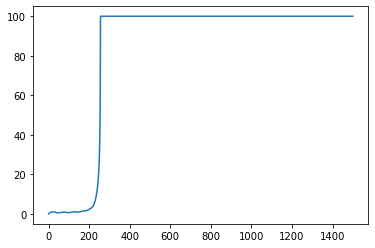

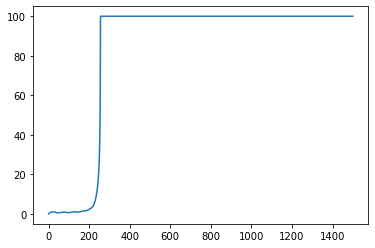

In [11]:
u_rel_err=np.linalg.norm(u_full-u_rom_g,ord=2,axis=1)/np.linalg.norm(u_full,ord=2,axis=1)*100
v_rel_err=np.linalg.norm(v_full-v_rom_g,ord=2,axis=1)/np.linalg.norm(v_full,ord=2,axis=1)*100

u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_rom_g,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
v_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(v_full-v_rom_g,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(v_full,ord=2,axis=1)**2))*100

u_max_rel_err = np.max(u_rel_err)
v_max_rel_err = np.max(v_rel_err)

print("Average relative error of u: {} %".format(u_avg_rel_err))
print("Average relative error of v: {} %".format(v_avg_rel_err))
print("Maximum relative error of u: {} %".format(u_max_rel_err))
print("Maximum relative error of v: {} %".format(v_max_rel_err))

relErr_LSROM_g[:,ii]=[u_avg_rel_err,v_avg_rel_err]
maxErr_LSROM_g[:,ii]=[u_max_rel_err,v_max_rel_err]

plt.plot(u_rel_err)
plt.show()

plt.plot(v_rel_err)
plt.show()

In [35]:
u_rel_err[254],u_rel_err[255],u_rel_err[256],u_rel_err[257]

(49.17929852066354, 63.356383934378094, 98.95852642489291, 100.0)

In [36]:
v_rel_err[254],v_rel_err[255],v_rel_err[256],v_rel_err[257]

(49.179298520663494, 63.356383934378016, 98.95852642489271, 100.0)

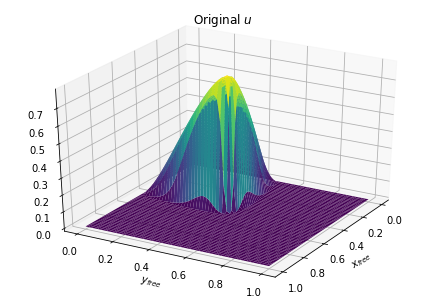

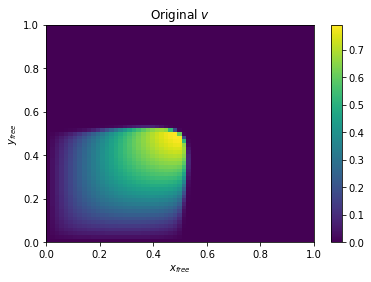

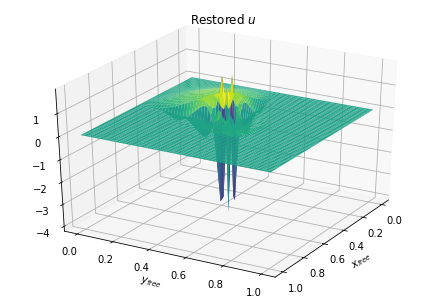

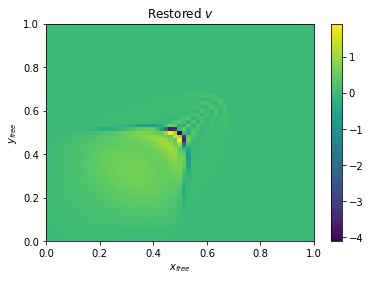

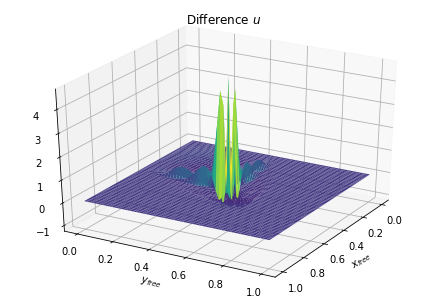

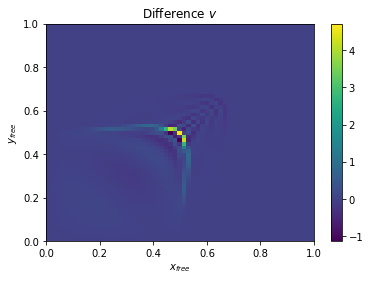

In [37]:
# generate mesh grid
[xv,yv]=np.meshgrid(np.linspace(0,1,nx),np.linspace(0,1,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

x_free=x[free_raveled_indicies]
y_free=y[free_raveled_indicies]

k=256

# plot origianl data
fig_u = plt.figure()
ax_u = Axes3D(fig_u)
ax_u.plot_surface(xv, yv, u_full[k].reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
ax_u.view_init(elev=30,azim=30)
# ax_u = fig_u.gca()
# p_u=ax_u.pcolor(xv, yv, u_full[k].reshape(ny,nx))
# cb_u=fig_u.colorbar(p_u,ax=ax_u)
ax_u.set_xlabel('$x_{free}$')
ax_u.set_ylabel('$y_{free}$')
plt.title('Original $u$')
plt.show()

fig_v = plt.figure()
# ax_v = Axes3D(fig_v)
# ax_v.plot_surface(xv, yv, v_full[k].reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
# ax_v.view_init(elev=30,azim=60)
ax_v = fig_v.gca()
p_v=ax_v.pcolor(xv, yv, v_full[k].reshape(ny,nx))
cb_v=fig_v.colorbar(p_v,ax=ax_v)
ax_v.set_xlabel('$x_{free}$')
ax_v.set_ylabel('$y_{free}$')
plt.title('Original $v$')
plt.show()


# plot restored data
fig_u = plt.figure()
ax_u = Axes3D(fig_u)
ax_u.plot_surface(xv, yv, u_rom_g[k].reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
ax_u.view_init(elev=30,azim=30)
# ax_u = fig_u.gca()
# p_u=ax_u.pcolor(xv, yv, u_rom_g[k].reshape(ny,nx))
# cb_u=fig_u.colorbar(p_u,ax=ax_u)
ax_u.set_xlabel('$x_{free}$')
ax_u.set_ylabel('$y_{free}$')
plt.title('Restored $u$')
plt.show()

fig_v = plt.figure()
# ax_v = Axes3D(fig_v)
# ax_v.plot_surface(xv, yv, v_rom_g[k].reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
# ax_v.view_init(elev=30,azim=60)
ax_v = fig_v.gca()
p_v=ax_v.pcolor(xv, yv, v_rom_g[k].reshape(ny,nx))
cb_v=fig_v.colorbar(p_v,ax=ax_v)
ax_v.set_xlabel('$x_{free}$')
ax_v.set_ylabel('$y_{free}$')
plt.title('Restored $v$')
plt.show()

# plot relative error
fig_u = plt.figure()
ax_u = Axes3D(fig_u)
ax_u.plot_surface(xv, yv, (u_full[k]-u_rom_g[k]).reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
ax_u.view_init(elev=30,azim=30)
# ax_u = fig_u.gca()
# p_u=ax_u.pcolor(xv, yv, (u_full[k]-u_rom_g[k]).reshape(ny,nx))
# cb_u=fig_u.colorbar(p_u,ax=ax_u)
ax_u.set_xlabel('$x_{free}$')
ax_u.set_ylabel('$y_{free}$')
plt.title('Difference $u$')
plt.show()

fig_v = plt.figure()
# ax_v = Axes3D(fig_v)
# ax_v.plot_surface(xv, yv, (v_full[k]-v_rom_g[k]).reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
# ax_v.view_init(elev=30,azim=60)
ax_v = fig_v.gca()
p_v=ax_v.pcolor(xv, yv, (v_full[k]-v_rom_g[k]).reshape(ny,nx))
cb_v=fig_v.colorbar(p_v,ax=ax_v)
ax_v.set_xlabel('$x_{free}$')
ax_v.set_ylabel('$y_{free}$')
plt.title('Difference $v$')
plt.show()

# Galerkin

In [ ]:
for ii in range(len(redDimArr_LSROM)):
    redDim=redDimArr_LSROM[ii]
    
    # load POD basis
    if Re==10000:
        POD_basis=redDim
        file_name_POD="./model/POD_high_Re_red-dim_{}.p".format(redDim)
    elif Re==100:
        POD_basis=redDim
        file_name_POD="./model/POD_low_Re_red-dim_{}.p".format(redDim)
    else:
        raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))

    POD = pickle.load(open(file_name_POD,'rb'))

    phi_u = POD['u']
    phi_v = POD['v']

    phi_u_pinv=np.linalg.pinv(phi_u)
    phi_v_pinv=np.linalg.pinv(phi_v)

    u_ref = u0[free_raveled_indicies]
    v_ref = v0[free_raveled_indicies]

    I_hat=np.eye(POD_basis)

    maxitr=10
    tol=1e-8
    
    Mphi_u=M.dot(phi_u)
    Nphi_u=N.dot(phi_u)
    Mphi_v=M.dot(phi_v)
    Nphi_v=N.dot(phi_v)

    Dxphi_u=Dx.dot(phi_u)
    Dyphi_u=Dy.dot(phi_u)
    Dxphi_v=Dx.dot(phi_v)
    Dyphi_v=Dy.dot(phi_v)

    au_cur=-1/dx*u_ref*(Mu_ref-Bdudx0_cur)-1/dy*v_ref*(Nu_ref-Bdudy0_cur) \
    +1/(Re*dx**2)*(Dxu_ref+bxu_cur)+1/(Re*dy**2)*(Dyu_ref+byu_cur)
    Bu_cur=-1/dx*(np.diag(u_ref).dot(Mphi_u)+np.diag(Mu_ref-Bdudx0_cur).dot(phi_u)) \
    -1/dy*np.diag(v_ref).dot(Nphi_u) \
    +1/(Re*dx**2)*Dxphi_u+1/(Re*dy**2)*Dyphi_u
    Cu_cur=-1/dy*np.diag(Nu_ref-Bdudy0_cur).dot(phi_v) 

    av_cur=-1/dx*u_ref*(Mv_ref-Bdvdx0_cur)-1/dy*v_ref*(Nv_ref-Bdvdy0_cur) \
    +1/(Re*dx**2)*(Dxv_ref+bxv_cur)+1/(Re*dy**2)*(Dyv_ref+byv_cur)
    Bv_cur=-1/dx*np.diag(Mv_ref-Bdvdx0_cur).dot(phi_u)
    Cv_cur=-1/dx*np.diag(u_ref).dot(Mphi_v) \
    -1/dy*(np.diag(v_ref).dot(Nphi_v)+np.diag(Nv_ref-Bdvdy0_cur).dot(phi_v)) \
    +1/(Re*dx**2)*Dxphi_v+1/(Re*dy**2)*Dyphi_v
    
    a1_cur=phi_u_pinv.dot(au_cur)
    A2_cur=phi_u_pinv.dot(Bu_cur)
    A3_cur=phi_u_pinv.dot(Cu_cur)

    b1_cur=phi_v_pinv.dot(av_cur)
    B2_cur=phi_v_pinv.dot(Bv_cur)
    B3_cur=phi_v_pinv.dot(Cv_cur)
    
    def theta_u(u_hat,v_hat):
        return -1/dx*phi_u.dot(u_hat)*Mphi_u.dot(u_hat)-1/dy*phi_v.dot(v_hat)*Nphi_u.dot(u_hat)

    def theta_v(u_hat,v_hat):
        return -1/dx*phi_u.dot(u_hat)*Mphi_v.dot(v_hat)-1/dy*phi_v.dot(v_hat)*Nphi_v.dot(v_hat)

    def dtheta_udu_hat(u_hat,v_hat):
        return -1/dx*(np.diag(Mphi_u.dot(u_hat)).dot(phi_u)+np.diag(phi_u.dot(u_hat)).dot(Mphi_u)) \
    -1/dy*(np.diag(phi_v.dot(v_hat)).dot(Nphi_u))

    def dtheta_udv_hat(u_hat,v_hat):
        return -1/dy*(np.diag(Nphi_u.dot(u_hat)).dot(phi_v))

    def dtheta_vdu_hat(u_hat,v_hat):
        return -1/dx*(np.diag(Mphi_v.dot(v_hat)).dot(phi_u))

    def dtheta_vdv_hat(u_hat,v_hat):
        return -1/dx*(np.diag(phi_u.dot(u_hat)).dot(Mphi_v)) \
    -1/dy*(np.diag(Nphi_v.dot(v_hat)).dot(phi_v)+np.diag(phi_v.dot(v_hat)).dot(Nphi_v))

    def f_u_hat(u_hat,v_hat,a1_cur,A2_cur,A3_cur):
        return a1_cur+A2_cur.dot(u_hat)+A3_cur.dot(v_hat)+phi_u_pinv.dot(theta_u(u_hat,v_hat))

    def f_v_hat(u_hat,v_hat,b1_cur,B2_cur,B3_cur):
        return b1_cur+B2_cur.dot(u_hat)+B3_cur.dot(v_hat)+phi_v_pinv.dot(theta_v(u_hat,v_hat))

    def df_u_hatdu_hat(u_hat,v_hat,A2_cur):
        return A2_cur+phi_u_pinv.dot(dtheta_udu_hat(u_hat,v_hat))

    def df_u_hatdv_hat(u_hat,v_hat,A3_cur):
        return A3_cur+phi_u_pinv.dot(dtheta_udv_hat(u_hat,v_hat))

    def df_v_hatdu_hat(u_hat,v_hat,B2_cur):
        return B2_cur+phi_v_pinv.dot(dtheta_vdu_hat(u_hat,v_hat))

    def df_v_hatdv_hat(u_hat,v_hat,B3_cur):
        return B3_cur+phi_v_pinv.dot(dtheta_vdv_hat(u_hat,v_hat))

    def r_hat(u_hat,v_hat,u_hat_prev,v_hat_prev,a1_cur,A2_cur,A3_cur,b1_cur,B2_cur,B3_cur):
        r_u_hat=u_hat-u_hat_prev-dt*f_u_hat(u_hat,v_hat,a1_cur,A2_cur,A3_cur)
        r_v_hat=v_hat-v_hat_prev-dt*f_v_hat(u_hat,v_hat,b1_cur,B2_cur,B3_cur)
        return np.concatenate((r_u_hat,r_v_hat))

    def J_hat(u_hat,v_hat,A2_cur,A3_cur,B2_cur,B3_cur):
        J_hat11=I_hat-dt*df_u_hatdu_hat(u_hat,v_hat,A2_cur)
        J_hat12=-dt*df_u_hatdv_hat(u_hat,v_hat,A3_cur)
        J_hat21=-dt*df_v_hatdu_hat(u_hat,v_hat,B2_cur)
        J_hat22=I_hat-dt*df_v_hatdv_hat(u_hat,v_hat,B3_cur)
        return np.block([[J_hat11,J_hat12],[J_hat21,J_hat22]])
    
    # solve ROM
    t_start_g=time.time()

    # solution
    u_rom_g=np.zeros((nt+1,ny*nx))
    v_rom_g=np.zeros((nt+1,ny*nx))
    u_reduced=np.zeros((nt+1,POD_basis))
    v_reduced=np.zeros((nt+1,POD_basis))

    # IC
    u_hat0=np.zeros(POD_basis)
    v_hat0=np.zeros(POD_basis)
    u_rom_g[0]=np.copy(u0)
    v_rom_g[0]=np.copy(v0)

    for k in range(nt):
    #     print("")
    #     print(k,"th time step:")

        u_hat_prev=np.copy(u_reduced[k])
        v_hat_prev=np.copy(v_reduced[k])

        u_hat=np.copy(u_reduced[k])
        v_hat=np.copy(v_reduced[k])

        residual_hat=r_hat(u_hat,v_hat,u_hat_prev,v_hat_prev,a1_cur,A2_cur,A3_cur,b1_cur,B2_cur,B3_cur)

        for itr in range(maxitr):
            Jacobian_hat=J_hat(u_hat,v_hat,A2_cur,A3_cur,B2_cur,B3_cur)

            delta_reduced=np.linalg.solve(Jacobian_hat,-residual_hat)

            u_hat+=delta_reduced[:POD_basis]
            v_hat+=delta_reduced[POD_basis:]

            residual_hat=r_hat(u_hat,v_hat,u_hat_prev,v_hat_prev,a1_cur,A2_cur,A3_cur,b1_cur,B2_cur,B3_cur)

            R=np.linalg.norm(residual_hat)
    #         print(itr,"th Newton iteration", "R:", R)

            if R<tol:
                u_reduced[k+1]=u_hat.copy()
                v_reduced[k+1]=v_hat.copy()
                u_rom_g[k+1,free_raveled_indicies]=u_ref+phi_u.dot(u_hat)
                v_rom_g[k+1,free_raveled_indicies]=v_ref+phi_v.dot(v_hat)
                # BC from exact solution
                u_rom_g[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
                v_rom_g[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()
                break

        if R>=tol:
            print("\n non converged after {}th iteration".format(maxitr))
            break  

    #     u_reduced[k+1]=u_hat.copy()
    #     v_reduced[k+1]=v_hat.copy()
    #     u_rom_g[k+1,free_raveled_indicies]=u_ref+phi_u.dot(u_hat)
    #     v_rom_g[k+1,free_raveled_indicies]=v_ref+phi_v.dot(v_hat)
    #     # BC from exact solution
    #     u_rom_g[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
    #     v_rom_g[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()

    t_elapsed_g=time.time()-t_start_g
    print()
    print('Time elapsed: {} sec'.format(t_elapsed_g))
    
    u_rel_err=np.linalg.norm(u_full-u_rom_g,ord=2,axis=1)/np.linalg.norm(u_full,ord=2,axis=1)*100
    v_rel_err=np.linalg.norm(v_full-v_rom_g,ord=2,axis=1)/np.linalg.norm(v_full,ord=2,axis=1)*100

    u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_rom_g,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
    v_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(v_full-v_rom_g,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(v_full,ord=2,axis=1)**2))*100

    u_max_rel_err = np.max(u_rel_err)
    v_max_rel_err = np.max(v_rel_err)

    print("Average relative error of u: {} %".format(u_avg_rel_err))
    print("Average relative error of v: {} %".format(v_avg_rel_err))
    print("Maximum relative error of u: {} %".format(u_max_rel_err))
    print("Maximum relative error of v: {} %".format(v_max_rel_err))
    
    relErr_LSROM_g[:,ii]=[u_avg_rel_err,v_avg_rel_err]
    maxErr_LSROM_g[:,ii]=[u_max_rel_err,v_max_rel_err]

# LSPG

In [ ]:
for ii in range(len(redDimArr_LSROM)):
    redDim=redDimArr_LSROM[ii]
    
    # load POD basis
    if Re==10000:
        POD_basis=redDim
        file_name_POD="./model/POD_high_Re_red-dim_{}.p".format(redDim)
    elif Re==100:
        POD_basis=redDim
        file_name_POD="./model/POD_low_Re_red-dim_{}.p".format(redDim)
    else:
        raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))

    POD = pickle.load(open(file_name_POD,'rb'))

    phi_u = POD['u']
    phi_v = POD['v']
    
    phi_uT=phi_u.T
    phi_vT=phi_v.T

    u_ref = u0[free_raveled_indicies]
    v_ref = v0[free_raveled_indicies]

    I_hat=np.eye(POD_basis)

    maxitr=10
    tol=1e-8
    
    Mphi_u=M.dot(phi_u)
    Nphi_u=N.dot(phi_u)
    Mphi_v=M.dot(phi_v)
    Nphi_v=N.dot(phi_v)

    Mphi_uT=Mphi_u.T
    Nphi_uT=Nphi_u.T
    Mphi_vT=Mphi_v.T
    Nphi_vT=Nphi_v.T

    Dxphi_u=Dx.dot(phi_u)
    Dyphi_u=Dy.dot(phi_u)
    Dxphi_v=Dx.dot(phi_v)
    Dyphi_v=Dy.dot(phi_v)

    au_cur=-1/dx*u_ref*(Mu_ref-Bdudx0_cur)-1/dy*v_ref*(Nu_ref-Bdudy0_cur) \
    +1/(Re*dx**2)*(Dxu_ref+bxu_cur)+1/(Re*dy**2)*(Dyu_ref+byu_cur)
    Bu_cur=-1/dx*(np.diag(u_ref).dot(Mphi_u)+np.diag(Mu_ref-Bdudx0_cur).dot(phi_u)) \
    -1/dy*np.diag(v_ref).dot(Nphi_u) \
    +1/(Re*dx**2)*Dxphi_u+1/(Re*dy**2)*Dyphi_u
    Cu_cur=-1/dy*np.diag(Nu_ref-Bdudy0_cur).dot(phi_v)

    av_cur=-1/dx*u_ref*(Mv_ref-Bdvdx0_cur)-1/dy*v_ref*(Nv_ref-Bdvdy0_cur) \
    +1/(Re*dx**2)*(Dxv_ref+bxv_cur)+1/(Re*dy**2)*(Dyv_ref+byv_cur)
    Bv_cur=-1/dx*np.diag(Mv_ref-Bdvdx0_cur).dot(phi_u)
    Cv_cur=-1/dx*np.diag(u_ref).dot(Mphi_v) \
    -1/dy*(np.diag(v_ref).dot(Nphi_v)+np.diag(Nv_ref-Bdvdy0_cur).dot(phi_v)) \
    +1/(Re*dx**2)*Dxphi_v+1/(Re*dy**2)*Dyphi_v

    a1_cur=-dt*au_cur
    A2_cur=phi_u-dt*Bu_cur
    A3_cur=-dt*Cu_cur
    A2T_cur=A2_cur.T
    A3T_cur=A3_cur.T

    b1_cur=-dt*av_cur
    B2_cur=-dt*Bv_cur
    B3_cur=phi_v-dt*Cv_cur
    B2T_cur=B2_cur.T
    B3T_cur=B3_cur.T

    A4_cur=-A2_cur.T.dot(phi_u)
    A5_cur=-B2_cur.T.dot(phi_v)
    a6_cur=A2_cur.T.dot(a1_cur)+B2_cur.T.dot(b1_cur)
    A7_cur=A2_cur.T.dot(A2_cur)+B2_cur.T.dot(B2_cur)
    A8_cur=A2_cur.T.dot(A3_cur)+B2_cur.T.dot(B3_cur)

    B4_cur=-A3_cur.T.dot(phi_u)
    B5_cur=-B3_cur.T.dot(phi_v)
    b6_cur=A3_cur.T.dot(a1_cur)+B3_cur.T.dot(b1_cur)
    B7_cur=A3_cur.T.dot(A2_cur)+B3_cur.T.dot(B2_cur)
    B8_cur=A3_cur.T.dot(A3_cur)+B3_cur.T.dot(B3_cur)

    def theta_u(u_hat,v_hat):
        return -1/dx*phi_u.dot(u_hat)*Mphi_u.dot(u_hat)-1/dy*phi_v.dot(v_hat)*Nphi_u.dot(u_hat)

    def theta_v(u_hat,v_hat):
        return -1/dx*phi_u.dot(u_hat)*Mphi_v.dot(v_hat)-1/dy*phi_v.dot(v_hat)*Nphi_v.dot(v_hat)

    def dtheta_udu_hat(u_hat,v_hat):
        return -1/dx*(np.diag(Mphi_u.dot(u_hat)).dot(phi_u)+np.diag(phi_u.dot(u_hat)).dot(Mphi_u)) \
    -1/dy*(np.diag(phi_v.dot(v_hat)).dot(Nphi_u))

    def dtheta_udv_hat(u_hat,v_hat):
        return -1/dy*(np.diag(Nphi_u.dot(u_hat)).dot(phi_v))

    def dtheta_vdu_hat(u_hat,v_hat):
        return -1/dx*(np.diag(Mphi_v.dot(v_hat)).dot(phi_u))

    def dtheta_vdv_hat(u_hat,v_hat):
        return -1/dx*(np.diag(phi_u.dot(u_hat)).dot(Mphi_v)) \
    -1/dy*(np.diag(Nphi_v.dot(v_hat)).dot(phi_v)+np.diag(phi_v.dot(v_hat)).dot(Nphi_v))

    def dtheta_udu_hatT(u_hat,v_hat):
        return -1/dx*(Mphi_u.dot(u_hat)*phi_uT+phi_u.dot(u_hat)*Mphi_uT) \
    -1/dy*(phi_v.dot(v_hat)*Nphi_uT)

    def dtheta_udv_hatT(u_hat,v_hat):
        return -1/dy*(Nphi_u.dot(u_hat)*phi_vT)

    def dtheta_vdu_hatT(u_hat,v_hat):
        return -1/dx*(Mphi_v.dot(v_hat)*phi_uT)

    def dtheta_vdv_hatT(u_hat,v_hat):
        return -1/dx*(phi_u.dot(u_hat)*Mphi_vT) \
    -1/dy*(Nphi_v.dot(v_hat)*phi_v.T+phi_v.dot(v_hat)*Nphi_vT)

    def r_hat(u_hat,v_hat,u_hat_prev,v_hat_prev,a1_cur,A2_cur,A3_cur,A2T_cur,A3T_cur,A4_cur,A5_cur,a6_cur,A7_cur,A8_cur,\
              b1_cur,B2_cur,B3_cur,B2T_cur,B3T_cur,B4_cur,B5_cur,b6_cur,B7_cur,B8_cur):

        r_u_hat=A4_cur.dot(u_hat_prev)+A5_cur.dot(v_hat_prev)+a6_cur+A7_cur.dot(u_hat)+A8_cur.dot(v_hat) \
        -dt*A2T_cur.dot(theta_u(u_hat,v_hat))-dt*B2T_cur.dot(theta_v(u_hat,v_hat)) \
        -dt*dtheta_udu_hatT(u_hat,v_hat).dot(-phi_u.dot(u_hat_prev)+a1_cur+A2_cur.dot(u_hat)+A3_cur.dot(v_hat)-dt*theta_u(u_hat,v_hat)) \
        -dt*dtheta_vdu_hatT(u_hat,v_hat).dot(-phi_v.dot(v_hat_prev)+b1_cur+B2_cur.dot(u_hat)+B3_cur.dot(v_hat)-dt*theta_v(u_hat,v_hat))

        r_v_hat=B4_cur.dot(u_hat_prev)+B5_cur.dot(v_hat_prev)+b6_cur+B7_cur.dot(u_hat)+B8_cur.dot(v_hat) \
        -dt*A3T_cur.dot(theta_u(u_hat,v_hat))-dt*B3T_cur.dot(theta_v(u_hat,v_hat)) \
        -dt*dtheta_udv_hatT(u_hat,v_hat).dot(-phi_u.dot(u_hat_prev)+a1_cur+A2_cur.dot(u_hat)+A3_cur.dot(v_hat)-dt*theta_u(u_hat,v_hat)) \
        -dt*dtheta_vdv_hatT(u_hat,v_hat).dot(-phi_v.dot(v_hat_prev)+b1_cur+B2_cur.dot(u_hat)+B3_cur.dot(v_hat)-dt*theta_v(u_hat,v_hat))

        return np.concatenate((r_u_hat,r_v_hat))

    def J_hat(u_hat,v_hat,A2_cur,A2T_cur,A3_cur,A3T_cur,A7_cur,A8_cur,B2_cur,B2T_cur,B3_cur,B3T_cur,B7_cur,B8_cur):

        J_hat11=A7_cur-dt*A2T_cur.dot(dtheta_udu_hat(u_hat,v_hat))-dt*B2T_cur.dot(dtheta_vdu_hat(u_hat,v_hat)) \
        -dt*dtheta_udu_hatT(u_hat,v_hat).dot(A2_cur-dt*dtheta_udu_hat(u_hat,v_hat)) \
        -dt*dtheta_vdu_hatT(u_hat,v_hat).dot(B2_cur-dt*dtheta_vdu_hat(u_hat,v_hat))

        J_hat12=A8_cur-dt*A2T_cur.dot(dtheta_udv_hat(u_hat,v_hat))-dt*B2T_cur.dot(dtheta_vdv_hat(u_hat,v_hat)) \
        -dt*dtheta_udu_hatT(u_hat,v_hat).dot(A3_cur-dt*dtheta_udv_hat(u_hat,v_hat)) \
        -dt*dtheta_vdu_hatT(u_hat,v_hat).dot(B3_cur-dt*dtheta_vdv_hat(u_hat,v_hat))

        J_hat21=B7_cur-dt*A3T_cur.dot(dtheta_udu_hat(u_hat,v_hat))-dt*B3T_cur.dot(dtheta_vdu_hat(u_hat,v_hat)) \
        -dt*dtheta_udv_hatT(u_hat,v_hat).dot(A2_cur-dt*dtheta_udu_hat(u_hat,v_hat)) \
        -dt*dtheta_vdv_hatT(u_hat,v_hat).dot(B2_cur-dt*dtheta_vdu_hat(u_hat,v_hat))

        J_hat22=B8_cur-dt*A3T_cur.dot(dtheta_udv_hat(u_hat,v_hat))-dt*B3T_cur.dot(dtheta_vdv_hat(u_hat,v_hat)) \
        -dt*dtheta_udv_hatT(u_hat,v_hat).dot(A3_cur-dt*dtheta_udv_hat(u_hat,v_hat)) \
        -dt*dtheta_vdv_hatT(u_hat,v_hat).dot(B3_cur-dt*dtheta_vdv_hat(u_hat,v_hat))

        return np.block([[J_hat11,J_hat12],[J_hat21,J_hat22]])
    
    # run ROM
    t_start_lspg=time.time()

    # solution
    u_rom_lspg=np.zeros((nt+1,ny*nx))
    v_rom_lspg=np.zeros((nt+1,ny*nx))
    u_reduced=np.zeros((nt+1,POD_basis))
    v_reduced=np.zeros((nt+1,POD_basis))

    # IC
    u_hat0=np.zeros(POD_basis)
    v_hat0=np.zeros(POD_basis)
    u_rom_lspg[0]=np.copy(u0)
    v_rom_lspg[0]=np.copy(v0)

    for k in range(nt):
    #     print("")
    #     print(k+1,"th time step:")

        u_hat_prev=np.copy(u_reduced[k])
        v_hat_prev=np.copy(v_reduced[k])

        u_hat=np.copy(u_reduced[k])
        v_hat=np.copy(v_reduced[k])

        residual_hat=r_hat(u_hat,v_hat,u_hat_prev,v_hat_prev,a1_cur,A2_cur,A3_cur,A2T_cur,A3T_cur,A4_cur,A5_cur,a6_cur,A7_cur,A8_cur,\
              b1_cur,B2_cur,B3_cur,B2T_cur,B3T_cur,B4_cur,B5_cur,b6_cur,B7_cur,B8_cur)

        for itr in range(maxitr):
            Jacobian_hat=J_hat(u_hat,v_hat,A2_cur,A2T_cur,A3_cur,A3T_cur,A7_cur,A8_cur,B2_cur,B2T_cur,B3_cur,B3T_cur,B7_cur,B8_cur)

            delta_reduced=np.linalg.solve(Jacobian_hat,-residual_hat)

            u_hat+=delta_reduced[:POD_basis]
            v_hat+=delta_reduced[POD_basis:]

            residual_hat=r_hat(u_hat,v_hat,u_hat_prev,v_hat_prev,a1_cur,A2_cur,A3_cur,A2T_cur,A3T_cur,A4_cur,A5_cur,a6_cur,A7_cur,A8_cur,\
              b1_cur,B2_cur,B3_cur,B2T_cur,B3T_cur,B4_cur,B5_cur,b6_cur,B7_cur,B8_cur)

            R=np.linalg.norm(residual_hat)
    #         print(itr,"th Newton iteration", "R:", R)

            if R<tol:
                u_reduced[k+1]=u_hat.copy()
                v_reduced[k+1]=v_hat.copy()
                u_rom_lspg[k+1,free_raveled_indicies]=u_ref+phi_u.dot(u_hat)
                v_rom_lspg[k+1,free_raveled_indicies]=v_ref+phi_v.dot(v_hat)
                # BC from exact solution
                u_rom_lspg[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
                v_rom_lspg[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()
                break

        if R>=tol:
            print("\n non converged after {}th iteration".format(maxitr))
            break  

    #     u_reduced[k+1]=u_hat.copy()
    #     v_reduced[k+1]=v_hat.copy()
    #     u_rom_lspg[k+1,free_raveled_indicies]=u_ref+phi_u.dot(u_hat)
    #     v_rom_lspg[k+1,free_raveled_indicies]=v_ref+phi_v.dot(v_hat)
    #     # BC from exact solution
    #     u_rom_lspg[k+1,fixed_raveled_indicies]=u[k+1,fixed_raveled_indicies].copy()
    #     v_rom_lspg[k+1,fixed_raveled_indicies]=v[k+1,fixed_raveled_indicies].copy()

    t_elapsed_lspg=time.time()-t_start_lspg
    print()
    print('Time elapsed: {} sec'.format(t_elapsed_lspg))
    
    u_rel_err=np.linalg.norm(u_full-u_rom_lspg,ord=2,axis=1)/np.linalg.norm(u_full,ord=2,axis=1)*100
    v_rel_err=np.linalg.norm(v_full-v_rom_lspg,ord=2,axis=1)/np.linalg.norm(v_full,ord=2,axis=1)*100

    u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_rom_lspg,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
    v_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(v_full-v_rom_lspg,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(v_full,ord=2,axis=1)**2))*100

    u_max_rel_err = np.max(u_rel_err)
    v_max_rel_err = np.max(v_rel_err)

    print("Average relative error of u: {} %".format(u_avg_rel_err))
    print("Average relative error of v: {} %".format(v_avg_rel_err))
    print("Maximum relative error of u: {} %".format(u_max_rel_err))
    print("Maximum relative error of v: {} %".format(v_max_rel_err))
    
    relErr_LSROM_lspg[:,ii]=[u_avg_rel_err,v_avg_rel_err]
    maxErr_LSROM_lspg[:,ii]=[u_max_rel_err,v_max_rel_err]   

# Plot errors

In [ ]:
# plt.figure()
# plt.plot(redDimArr_LSROM,relErr_LSROM_g[0],redDimArr_LSROM,relErr_LSROM_lspg[0],redDimArr_LSROM,proErr_LSROM[0])
# plt.legend(['LS-ROM-g','LS-ROM-lspg','LS proj. error'])
# plt.xlabel('Reduced dimension')
# plt.ylabel('Avg. rel. error of u (%)')
# plt.show()

# plt.figure()
# plt.plot(redDimArr_LSROM,relErr_LSROM_g[1],redDimArr_LSROM,relErr_LSROM_lspg[1],redDimArr_LSROM,proErr_LSROM[1])
# plt.legend(['LS-ROM-g','LS-ROM-lspg','LS proj. error'])
# plt.xlabel('Reduced dimension')
# plt.ylabel('Avg. rel. error of v (%)')
# plt.show()

In [ ]:
# plt.figure()
# plt.plot(redDimArr_LSROM,maxErr_LSROM_g[0],redDimArr_LSROM,maxErr_LSROM_lspg[0],redDimArr_LSROM,proErr_LSROM[0])
# plt.legend(['LS-ROM-g','LS-ROM-lspg','LS proj. error'])
# plt.xlabel('Reduced dimension')
# plt.ylabel('Max. rel. error of u (%)')
# plt.show()

# plt.figure()
# plt.plot(redDimArr_LSROM,maxErr_LSROM_g[1],redDimArr_LSROM,maxErr_LSROM_lspg[1],redDimArr_LSROM,proErr_LSROM[1])
# plt.legend(['LS-ROM-g','LS-ROM-lspg','LS proj. error'])
# plt.xlabel('Reduced dimension')
# plt.ylabel('Max. rel. error of v (%)')
# plt.show()

# Save data to mat file

In [ ]:
dict_err={"relErr_LSROM_g":relErr_LSROM_g,"relErr_LSROM_lspg":relErr_LSROM_lspg,\
          "maxErr_LSROM_g":maxErr_LSROM_g,"maxErr_LSROM_lspg":maxErr_LSROM_lspg,\
          'proErr_LSROM':proErr_LSROM,'redDimArr_LSROM':redDimArr_LSROM}
savemat("./data/LSROM_Err.mat",dict_err)

pickle.dump(dict_err,open('./data/LSROM_Err.p','wb'))